# Projet DSOML - Comparison of SDCA and Subgradient Descent Algorithms on Support Vector Machines

## Victor Journe, Ludovic Lelievre

In [42]:
import pandas
import datetime
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn import svm, metrics, preprocessing
from sklearn.externals import joblib
import os
%matplotlib inline
from matplotlib import pyplot as plt
import datetime
import random
import timeit
from IPython.display import Image

np.random.seed(123)  # for reproducibility

#PATH = "/Users/ludoviclelievre/Dropbox/Docs Share/DSOML/"
PATH = "C:\Users\KD5299\Documents\Dropbox\Docs Share\DSOML/"

# Introduction

This project proposes to apply and compare two algorithms of Support Vector Machine. The goal is to classify an electricity market direction, long or short. 
Namely, the algorithms used in this notebook are:
1. SDCA algorithm (Dual method) <a href="http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf">Stochastic Dual Coordinate Ascent Methods for Regularized Loss
Minimization</a>.
2. Sub gradient descent algorithm (Primal method) <a href="http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf">Pegasos: Primal Estimated sub-GrAdient SOlver for SVM</a>.

# Data

Here is a quick view of the data; about 60 predictors and 100 000 samples.

In [44]:
df = pandas.read_csv(os.path.join(PATH,"ds_spark.txt"), sep=",", encoding="utf-8", index_col=0,parse_dates=True)
df.head()

,100MW,100MW_-m08,100MW_m08,-300MW,-300MW_-m08,-300MW_m08,R2_D_P_tot_s2,R2_D_P_tot_m296,Max,Max_-m08,...,NRV_s2,NRV_s3,NRV_s4,NRV_m18,R2_I_P_tot_s2,R2_I_P_tot_m296,PPOS,hour,month,day
2014-01-03 17:45:00,66.46,66.406667,64.925556,-156.7,-156.7,-156.7,22.77,20.568105,372.49,351.343333,...,16.322,86.499,147.100,62.027625,66.46,67.684842,110.11,17,1,4
2014-01-03 18:00:00,66.46,66.424444,65.231111,-156.7,-156.7,-156.7,22.77,20.544421,352.44,348.282222,...,111.153,16.322,86.499,84.259125,66.46,67.609053,140.25,18,1,4
2014-01-03 18:15:00,66.55,66.370000,65.546667,-156.7,-156.7,-156.7,22.77,20.454211,352.44,347.448889,...,177.231,111.153,16.322,105.984875,66.46,67.502316,140.25,18,1,4
2014-01-03 18:30:00,65.86,66.084444,65.785556,-156.7,-156.7,-156.7,21.54,20.419158,352.44,346.615556,...,208.363,177.231,111.153,129.275125,66.46,67.344421,140.25,18,1,4
2014-01-03 18:45:00,66.55,65.875556,66.101111,-156.7,-156.7,-156.7,21.54,20.382105,352.44,345.782222,...,213.468,208.363,177.231,130.510375,66.55,67.188947,140.25,18,1,4


In [45]:
# target varaible: -1 = short price; 1 = long price
df['target'] = ((df['PPOS']-df['BELIX PRICE']) > 0)*1 
df['target'][df['target']==0] = -1


C:\Users\KD5299\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


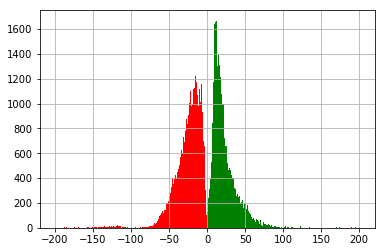

In [46]:
# histogramme prix a la baisse/prix a la hausse
ax =(df[df['target']>0]['PPOS']-df[df['target']>0]['BELIX PRICE']).hist(range = (-200, 200), bins=500, color = 'g',)
(df[df['target']<0]['PPOS']-df[df['target']<0]['BELIX PRICE']).hist(range = (-200, 200), bins=500, color = 'r',ax=ax)

The histogram above depicts the market price ditribution across 3 years of history. The two classes that we want to classify are in red and green. 

In [48]:
# train set
train_set = df[df.index<datetime.datetime(2016,1,1)]
train_target = train_set['target']
train_set = train_set.drop('target',axis=1)
print('target = -1 dans train set: ',sum(train_target==-1))
print('target = 1 dans train set: ',sum(train_target==1))
# test set
test_set = df[df.index>=datetime.datetime(2016,1,1)]
test_target = test_set['target']
test_set = test_set.drop('target',axis=1)
print('target = -1 dans test set: ',sum(test_target==-1))
print('target = 1 dans test set: ',sum(test_target==1))

('target = -1 dans train set: ', 35328)
('target = 1 dans train set: ', 33589)
('target = -1 dans test set: ', 14049)
('target = 1 dans test set: ', 11200)


Il est préférable lorsque l'on utilise les SVM de travailler avec des données normalisées. Nous centrons et réduisons les variables de notre train set et utilisons cette même transformation pour nos données dans le test set.

In [49]:
# on scale les input du train_set
scaler = preprocessing.StandardScaler().fit(train_set)
train_set = scaler.transform(train_set)
# on utilise la meme transformation sur les inputs du test_set
test_set = scaler.transform(test_set)

Avant d'implémenter les algorithmes SDCA et Pegasos, nous définissons deux fonctions qui seront utilisées dans la suite du rapport:
* Une fonction calculant le primal cost.
* Une fonction calculant la matrice de confusion.

In [50]:
def cost_func(x,y,w,n,l):
    mat_ones = np.ones(n)
    mat_zeros = np.zeros(n)
    hinge_loss = np.maximum(mat_zeros, mat_ones - y*np.dot(x,w))
    regularisation = np.dot(w,w)*l/2
    res = sum(hinge_loss)/n + regularisation
    return res

# compute confusion matrix
def get_confusion_matrix(x_test,y_test,w):
    y_pred = np.dot(x_test,w)
    y_pred[y_pred<0] = -1
    y_pred[y_pred>=0] = 1
    res = metrics.confusion_matrix(y_test, y_pred)
    return res

# SDCA Algorithm

L'approche en dual coordinate ascent (DCA) avec une pénalité l2 a pour objectif de résoudre le problème: $$max_{\alpha\in R^n}D(\alpha)$$ où $$D(\alpha)=[\frac{1}{n}\sum_{i=1}^{n} -\phi_{i}^{*}(-\alpha_{i})-\frac{\lambda}{2}\|\frac{1}{\lambda n}\sum_{i=1}^{n}\alpha_{i}x_{i}\|^2]$$ avec dans le cas de la hinge loss $$\phi_{i}^{*}(-\alpha) = -\alpha y_{i}$$

L'algorithme SDCA est présenté ci-dessous

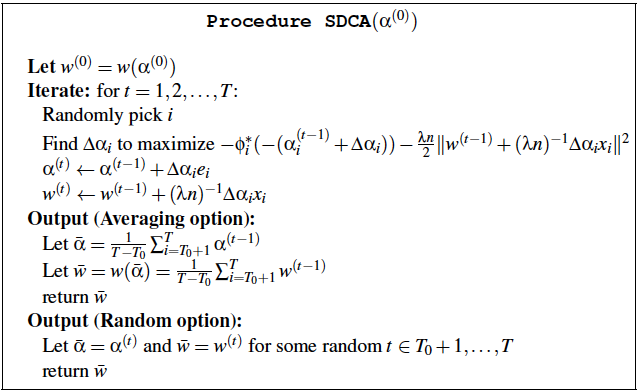

In [51]:
Image(filename=os.path.join(PATH,"images/procedure_SDCA.png"))

Dans le cas d'un SVM, on utilise la hinge loss. Dans ce cas $\Delta\alpha_{i}$ a une forme close: $$\Delta\alpha_{i}=y_{i}max(0,min(1,\frac{1-x_{i}^{T}w^{(t-1)}y_{i}}{\|x_{i}\|^2/((\lambda n)}+\alpha_{i}^{(t-1)}y_{i}))-\alpha_{i}^{(t-1)}$$

In [52]:
# set variables
niter = 3*10**4            # number of iterations
T0 = niter/2               # iteration at which we start computing the average omega
n = train_set.shape[0]     # number of examples in the train_set
m = train_set.shape[1]     # number of variables
n_test = test_set.shape[0] # number of examples in the test_set
l = 0.01                   # regularization parameter

In [53]:
# initialize variables
alpha = np.zeros(n)
omega = np.dot(train_set.transpose(), alpha)/(l*n)
average_omega = np.zeros(m)
cost_mat_SDCA = np.zeros(shape=(3,niter/1000+1))
error_mat_SDCA =  np.zeros(shape=(3,niter/1000+1))
place = 0
print('primal cost beginning SDCA: ', cost_func(train_set, train_target, omega, n, l))

('primal cost beginning SDCA: ', 1.0)


In [54]:
# SDCA Algorithm

# define beginning time
start_time = timeit.default_timer()

for it in np.arange(niter+1):
    # save cost and error every 1000 epochs
    if it%1000==0:
        # time spent
        time_spent = timeit.default_timer() - start_time

        # cost function
        cost = cost_func(train_set, train_target, omega, n, l)
        cost_mat_SDCA[0,place] = cost
        cost_mat_SDCA[1,place] = it
        cost_mat_SDCA[2,place] = time_spent
        # error
        conf_mat = get_confusion_matrix(test_set, test_target, omega)
        error = float(conf_mat[0][1]+conf_mat[1][0])/n_test
        error_mat_SDCA[0,place] = error
        error_mat_SDCA[1,place] = it
        error_mat_SDCA[2,place] = time_spent
        
        
        # update place
        place+=1
        
    # randomly pick i
    i = np.random.randint(0,n)
    # compute ∆ai
    xi = train_set[i,:]
    yi = train_target[i]
    alpha_i = alpha[i]
    A = np.dot(xi,xi)/(l*n)
    B = np.dot(xi, omega)
    delta_tilde = (yi-B)/A
    delta = yi*max(0, min(1,yi*(delta_tilde+alpha_i))) - alpha_i
    # update variables
    alpha[i]+=delta
    omega+=(delta*xi)/(l*n)
    
    # from T0, compute average omega
    if (it+1)>=T0:
        average_omega+=omega

average_omega = average_omega/(niter-T0)  
cost_final_SDCA = cost_func(train_set, train_target, average_omega, n, l)  
print('Primal cost end SDCA: ', cost_final_SDCA)
conf_mat_SDCA = get_confusion_matrix(test_set, test_target, average_omega)
print('Confusion matrix SDCA: ', conf_mat_SDCA)

('Primal cost end SDCA: ', 0.57342745133963513)
('Confusion matrix SDCA: ', array([[10657,  3392],
       [ 2997,  8203]]))


# Pegasos Algorithm

Le problème d'optimisation que l'algorithme Pegasos tente de résoudre dans le cadre d'un SVM avec pénalité l2 est le suivant: $$min_{w}\frac{\lambda}{2}\|w\|^{2}+\frac{1}{n}\sum_{(x,y)\in S}l(w;(x,y))$$
avec dans le cadre de la hinge loss: $$l(w;(x,y))=max(0,1-y<w,x>)$$

L'algorithme Pegasos est présenté ci-dessous

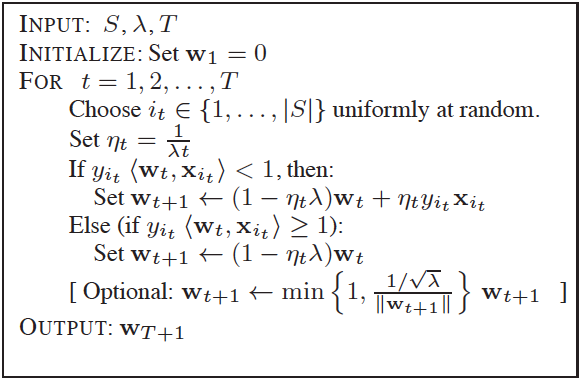

In [55]:
Image(filename=os.path.join(PATH,"images/procedure_Pegasos.png"))

In [56]:
# set variables
niter = 3*10**4            # number of iterations
T0 = niter/2               # iteration at which we start computing the average omega
n = train_set.shape[0]     # number of examples in the train_set
m = train_set.shape[1]     # number of variables
n_test = test_set.shape[0] # number of examples in the test_set
l = 0.01                   # regularization parameter

In [57]:
# initialize variables
omega = np.zeros(m)
average_omega = np.zeros(m)
cost_mat_SGD = np.zeros(shape=(3,niter/1000+1))
error_mat_SGD =  np.zeros(shape=(3,niter/1000+1))
place = 0
print('primal cost beginning SGD: ', cost_func(train_set, train_target, omega, n, l))

('primal cost beginning SGD: ', 1.0)


In [58]:
# Pegasos Algorithm

# define beginning time
start_time = timeit.default_timer()

for it in np.arange(niter+1):
    # save cost and error every 1000 epochs
    if it%1000==0:
        # time spent
        time_spent = timeit.default_timer() - start_time
        # cost function
        cost = cost_func(train_set, train_target, omega, n, l)
        cost_mat_SGD[0,place] = cost
        cost_mat_SGD[1,place] = it
        cost_mat_SGD[2,place] = time_spent
        # error
        conf_mat = get_confusion_matrix(test_set, test_target, omega)
        error = float(conf_mat[0][1]+conf_mat[1][0])/n_test
        error_mat_SGD[0,place] = error
        error_mat_SGD[1,place] = it
        error_mat_SGD[2,place] = time_spent
        
        
        # update place
        place+=1
        
    # randomly pick i
    i = np.random.randint(0,n)
    xi = train_set[i,:]
    yi = train_target[i]
    # update step size
    eta = 1/(l*(it+1))
    # update omega
    if yi*np.dot(xi,omega) < 1:
        omega = np.dot(1-eta*l, omega) + np.dot(eta*yi,xi)
    else:
        omega = np.dot(1-eta*l, omega) 
        
    # from T0, compute average omega
    if (it+1)>=T0:
        average_omega+=omega
        
    
average_omega = average_omega/(niter-T0)         
cost_final_SGD = cost_func(train_set, train_target, average_omega, n, l)  
print('Primal cost end SGD: ', cost_final_SGD)
conf_mat_SGD = get_confusion_matrix(test_set, test_target, average_omega)
print('Confusion matrix SGD: ',conf_mat_SGD)

('Primal cost end SGD: ', 0.58231233083897271)
('Confusion matrix SGD: ', array([[10489,  3560],
       [ 2904,  8296]]))


# Scikit learn SVM Algorithm

In [59]:
lin_clf = svm.LinearSVC(C=0.01, loss='hinge', penalty='l2', dual=True, fit_intercept=False)
lin_clf.fit(train_set, train_target)     
pred = lin_clf.predict(test_set)
cost_final_sklearn = cost_func(train_set, train_target, lin_clf.coef_[0], n, l)
print('Primal cost end sklearn: ', cost_final_sklearn)
print('Confusion matrix sklearn SVM: ',metrics.confusion_matrix(test_target, pred))

('Primal cost end sklearn: ', 0.57364091789379101)
('Confusion matrix sklearn SVM: ', array([[10600,  3449],
       [ 2967,  8233]]))


Les résultats obtenus à partir de l'algorithme SDCA sont très proches de ceux obtenus grâce à scikit learn en terme de fonction de coût et de matrice de confusion. Les résultats obtenus à partir de l'algorithme Pegasos sont legèrement inférieurs.

# Comparison SDCA and Pegasos Algorithms

In [60]:
# load array

## SDCA algorithm
#cost_mat_SDCA = np.load(os.path.join(PATH,'cost_mat_SDCA.npy'))
#error_mat_SDCA = np.load(os.path.join(PATH,'error_mat_SDCA.npy'))
## Pegasos algorithm
#cost_mat_SGD = np.load(os.path.join(PATH,'cost_mat_SGD.npy'))
#error_mat_SGD = np.load(os.path.join(PATH,'error_mat_SGD.npy'))

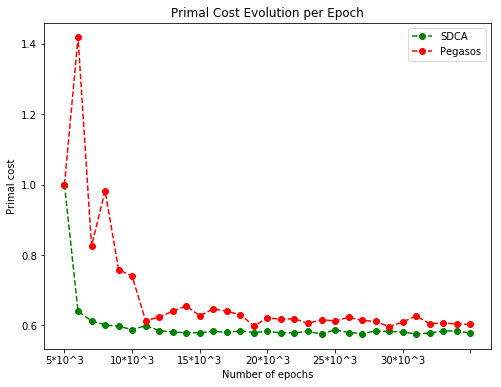

In [61]:
# Graph Primal cost per epoch
fig_cost_epoch = plt.figure(figsize=(8,6))
plt.title('Primal Cost Evolution per Epoch')
ax1_cost_epoch = fig_cost_epoch.add_subplot(1,1,1)
ax1_cost_epoch.plot(cost_mat_SDCA[0,:],color='g',marker='o',linestyle='dashed',label='SDCA')
ax1_cost_epoch.plot(cost_mat_SGD[0,:],color='r',marker='o',linestyle='dashed',label='Pegasos')
ax1_cost_epoch.set_xticklabels([str(l)+"*10^3" for l in range(0,31,5)])
ax1_cost_epoch.set_xlabel('Number of epochs')
ax1_cost_epoch.set_ylabel('Primal cost')
ax1_cost_epoch.legend(loc='best')

L'algorithme Pegasos est trop aggressif au début du problème d'optimisation. Il en résulte une augmentation de la fonction de coût lors des premières itérations. L'algorithme SDCA au contraire converge dès les premières itérations.

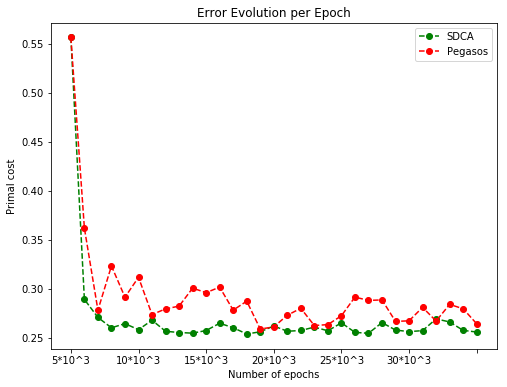

In [62]:
# Graph Error per epoch
fig_error_epoch = plt.figure(figsize=(8,6))
plt.title('Error Evolution per Epoch')
ax1_error_epoch = fig_error_epoch.add_subplot(1,1,1)
ax1_error_epoch.plot(error_mat_SDCA[0,:],color='g',marker='o',linestyle='dashed',label='SDCA')
ax1_error_epoch.plot(error_mat_SGD[0,:],color='r',marker='o',linestyle='dashed',label='Pegasos')
ax1_error_epoch.set_xticklabels([str(l)+"*10^3" for l in range(0,31,5)])
ax1_error_epoch.set_xlabel('Number of epochs')
ax1_error_epoch.set_ylabel('Primal cost')
ax1_error_epoch.legend(loc='best')

L'erreur de classification commise par l'algorithme Pegasos sur le test set oscille tout au long des itérations, contrairement à l'algorithme SDCA dont l'erreur de classification sur le test set se stabilise dès les premières itérations. De plus l'erreur de classification commise par l'algorithme Pegasos reste toujours supérieure à l'erreur commise par l'algorithme SDCA. 

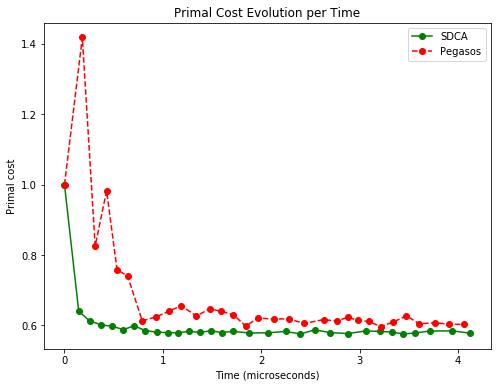

In [63]:
# Graph Primal cost per time
fig_cost_time = plt.figure(figsize=(8,6))
plt.title('Primal Cost Evolution per Time')
ax1_cost_time = fig_cost_time.add_subplot(1,1,1)
ax1_cost_time.plot(cost_mat_SDCA[2,:],cost_mat_SDCA[0,:],color='g',marker='o',zorder=2,label='SDCA')
ax1_cost_time.plot(cost_mat_SGD[2,:],cost_mat_SGD[0,:],color='r',marker='o',linestyle='dashed',label='Pegasos')
ax1_cost_time.set_xlabel('Time (microseconds)')
ax1_cost_time.set_ylabel('Primal cost')
ax1_cost_time.legend(loc='best')

L'algorithme SDCA converge très rapidement en temps. L'algorithme Pegasos met plus de temps à converger.

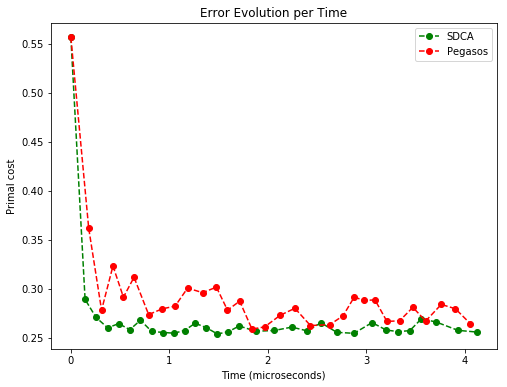

In [64]:
# Graph Error per time
fig_error_time = plt.figure(figsize=(8,6))
plt.title('Error Evolution per Time')
ax1_error_time = fig_error_time.add_subplot(1,1,1)
ax1_error_time.plot(error_mat_SDCA[2,:],error_mat_SDCA[0,:],color='g',marker='o',linestyle='dashed',label='SDCA')
ax1_error_time.plot(error_mat_SGD[2,:],error_mat_SGD[0,:],color='r',marker='o',linestyle='dashed',label='Pegasos')
ax1_error_time.set_xlabel('Time (microseconds)')
ax1_error_time.set_ylabel('Primal cost')
ax1_error_time.legend(loc='best')

L'algorithme SDCA converge plus rapidement en temps que l'algorithme Pegasos. De plus l'erreur de classification commise par l'algorithme Pegasos reste toujours supérieure à l'erreur commise par l'algorithme SDCA, ce qui implique que dans notre cas l'algorithme SDCA permet d'obtenir une classification plus précise. 

# Conclusion

Ce projet nous a permis d'appliquer et de comparer l'approche primale (Pegasos) et duale (SDCA) des algorithmes d'optimisation dans le cadre des SVM. 

Il en ressort que:
1. L'algorithme Pegasos tend à être trop aggressif au début du problème d'optimisation. La fonction de coût augmente au début des itérations avant de diminuer et de converger. L'algorithme SDCA, au contraire, converge dès les premières itérations.
2. L'algorithme SDCA converge plus rapidement en temps que l'algorithme Pegasos.